# Tutorial

This experiment simulates Majorana zero modes on the IBM Quantum hardware.
The results are published at [arXiv:2206.00563](https://arxiv.org/abs/2206.00563).

## Background
The Kitaev Hamiltonian is given by

$$
    H =
    -t \sum_j (a_j^\dagger a_{j + 1} + a_{j + 1}^\dagger a_{j})
    + \sum_j (\Delta a_j^\dagger a_{j + 1}^\dagger + \Delta^* a_{j + 1} a_j)
    + \mu (\sum_j a_j^\dagger a_j - \frac12)
$$

where $t$ is the tunneling amplitude, $\Delta$ is the superconducting gap, $\mu$ is the
chemical potential, and the $\{a_j\}$ are fermionic annihilation operators which satisfy the anticommutation relations

$$
    \begin{align}
        a_j a_k + a_k a_j &= 0 \\
        a_j a^\dagger_k + a^\dagger_k a_j &= \delta_{pq}
    \end{align}.
$$

The adjoint of an annihilation operator is called a creation operator, and together they are called fermionic ladder operators.

The Kitaev Hamiltonian is quadratic in the fermionic ladder operators. Eigenstates of quadratic Hamiltonians are called _fermionic Gaussian states_. They can be efficiently prepared on a quantum computer.

## State preparation

The `qiskit_research.mzm_generation` module contains a utility function for generating a Kitaev Hamiltonian. The object returned is an instance of the `QuadraticHamiltonian` class from Qiskit Nature. The general form of a quadratic Hamiltonian is

$$
    H =
    \sum_{j, k} M_{jk} a^\dagger_j a_k
    + \frac12 \sum_{j, k}
        (\Delta_{jk} a^\dagger_j a^\dagger_k + \Delta^*_{jk} a_k a_j)
    + \text{constant}
$$

where $M$ is a Hermitian matrix and $\Delta$ is an antisymmetric matrix. The `QuadraticHamiltonian` class stores these matrices (and the constant) as its internal representation of the Hamiltonian.

In [1]:
from qiskit_research.mzm_generation import kitaev_hamiltonian

n_modes = 3
tunneling = -1.0
superconducting = 1.0
chemical_potential = 1.0

hamiltonian = kitaev_hamiltonian(
    n_modes=n_modes,
    tunneling=tunneling,
    superconducting=superconducting,
    chemical_potential=chemical_potential,
)

print("Hermitian part:")
print(hamiltonian.hermitian_part)
print()
print("Antisymmetric part:")
print(hamiltonian.antisymmetric_part)

Hermitian part:
[[1. 1. 0.]
 [1. 1. 1.]
 [0. 1. 1.]]

Antisymmetric part:
[[ 0.  1.  0.]
 [-1.  0.  1.]
 [ 0. -1.  0.]]


A quadratic Hamiltonian can always be rewritten in the form

$$
    H = \sum_{j} \varepsilon_j b^\dagger_j b_j + \text{constant}
$$

where $\varepsilon_0 \leq \varepsilon_1 \leq \cdots \leq \varepsilon_N$ are non-negative real numbers and
the $\{b_j^\dagger\}$ are a new set of fermionic creation operators
that also satisfy the canonical anticommutation relations.
These new creation operators are linear combinations of the original creation and annihilation operators:

$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    a_1 \\
    \vdots \\
    a_N
    \end{pmatrix},
$$

where $W$ is an $N \times 2N$ matrix. Given a basis of eigenvectors of the Hamiltonian, each eigenvector is labeled by a subset of $\{0, \ldots, N - 1\}$, which we call the occupied orbitals. The corresponding eigenvalue is the sum of the corresponding values of $\varepsilon_j$, plus the constant.

Using Qiskit Nature, we can obtain the transformation matrix $W$ and construct a circuit to prepare an eigenvector of the Hamiltonian.

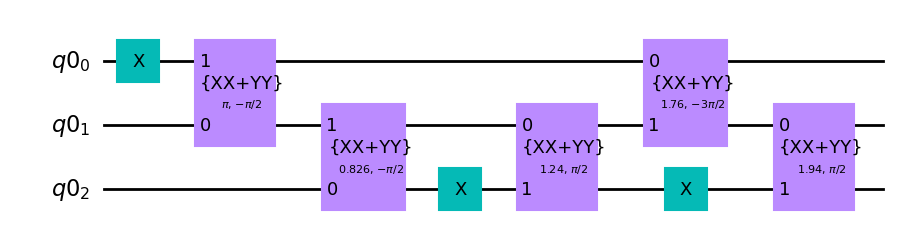

In [2]:
from qiskit_nature.circuit.library import FermionicGaussianState

transformation_matrix, _, _ = hamiltonian.diagonalizing_bogoliubov_transform()
occupied_orbitals = (1,)

circuit = FermionicGaussianState(
    transformation_matrix, occupied_orbitals=occupied_orbitals
)
circuit.draw("mpl")

## Measurement

All quantities of interest can be
determined from the correlation matrix, which is defined as the block matrix

$$
\begin{align}
    \Gamma =
    \begin{pmatrix}
        T & S \\
        -S^* & T^T
    \end{pmatrix}
\end{align}
$$

where

$$
\begin{align}
    T_{ij} &= \langle a^\dagger_i a_j \rangle \\
    S_{ij} &= \langle a^\dagger_i a^\dagger_j \rangle.
\end{align}
$$

The correlation matrix is obtained by measuring the operators

$$
\begin{align}
    a_j^\dagger a_k + a_k^\dagger a_j \\
    -i(a_j^\dagger a_k - a_k^\dagger a_j) \\
    a_j^\dagger a_k^\dagger + a_k a_j \\
    -i(a_j^\dagger a_k^\dagger - a_k a_j)
\end{align}
$$

By using virtual fermionic swaps, only measurements between neighboring modes are needed. For neighboring modes, the Jordan-Wigner transformation of these operators is

$$
    \begin{align}
        a_j^\dagger a_k + a_k^\dagger a_j &\mapsto \frac{X_j X_k + Y_j Y_k}{2} \\
        -i(a_j^\dagger a_k - a_k^\dagger a_j) &\mapsto \frac{X_j Y_k - Y_j X_k}{2} \\
        a_j^\dagger a_k^\dagger + a_k a_j &\mapsto \frac{X_j X_k - Y_j Y_k}{2} \\
        -i(a_j^\dagger a_k^\dagger - a_k a_j) &\mapsto \frac{-X_j Y_k - Y_j X_k}{2}
    \end{align}.
$$

While these operators can be measured straighforwardly by measuring the individual Pauli terms, we take a different approach. Because the fermionic Gaussian state has a fixed parity, we would like to perform the measurement in a way that does not disturb the parity. That way, we can be sure that any measured bitstrings with the incorrect parity must have resulted from an incorrect execution, so we can discard them as an error mitigation technique. These measurements can be accomplished using the two-qubit gates with the following matrices:

$$
U_1 =
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
    0 & -\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
    0 & 0 & 0 & 1 \\
\end{pmatrix}, \quad
U_2 =
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}}i & 0 \\
    0 & -\frac{1}{\sqrt{2}}i & \frac{1}{\sqrt{2}} & 0 \\
    0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

$$
U_3 =
\begin{pmatrix}
    \frac{1}{\sqrt{2}} & 0 & 0 & \frac{1}{\sqrt{2}} \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    -\frac{1}{\sqrt{2}} & 0 & 0 & \frac{1}{\sqrt{2}} \\
\end{pmatrix}, \quad
U_4 =
\begin{pmatrix}
    \frac{1}{\sqrt{2}} & 0 & 0 & \frac{1}{\sqrt{2}}i \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    \frac{1}{\sqrt{2}}i & 0 & 0 & \frac{1}{\sqrt{2}} \\
\end{pmatrix}
$$

These gates can be implemented using `XXPlusYYGate` and `XXMinusYYGate`.

Once the state is prepared, the operators between neighboring modes can immediately be measured. This requires two separate circuits, one to measure the operator between pairs of qubits where the first qubit is even-indexed, and another circuit to measure pairs of qubits where the first qubit is odd-indexed. In order to measure operators between qubits that are not neighbors, a naive approach would use fermionic swap gates to permute the modes. However, the same effect can be achieved by permuting the transformation matrix used to construct the circuit, which amounts to a relabeling of the fermionic modes. This enables all the required operators to be measured using circuits with the same number of gates.

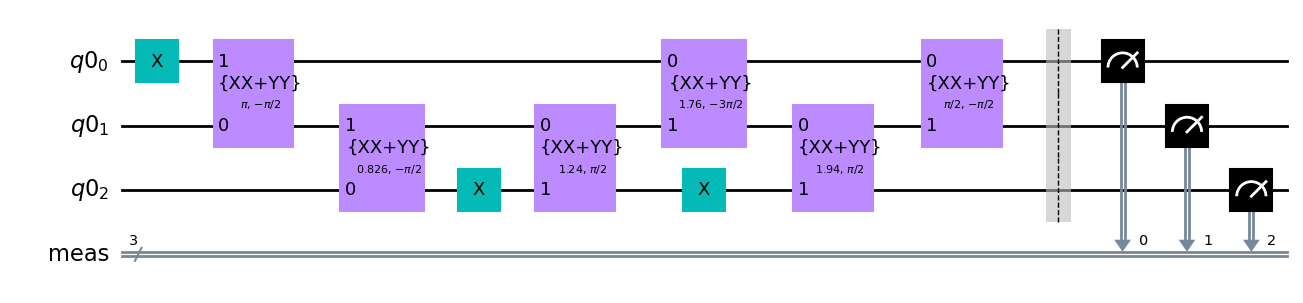

In [3]:
from qiskit_research.mzm_generation import measure_interaction_op

measurement_circuit = measure_interaction_op(circuit, "tunneling_plus_even")

measurement_circuit.draw("mpl")

## Transpilation

In order to execute a circuit on a hardware backend, it must be transpiled into gates supported by the backend.

/tmp/ipykernel_3091/731090725.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


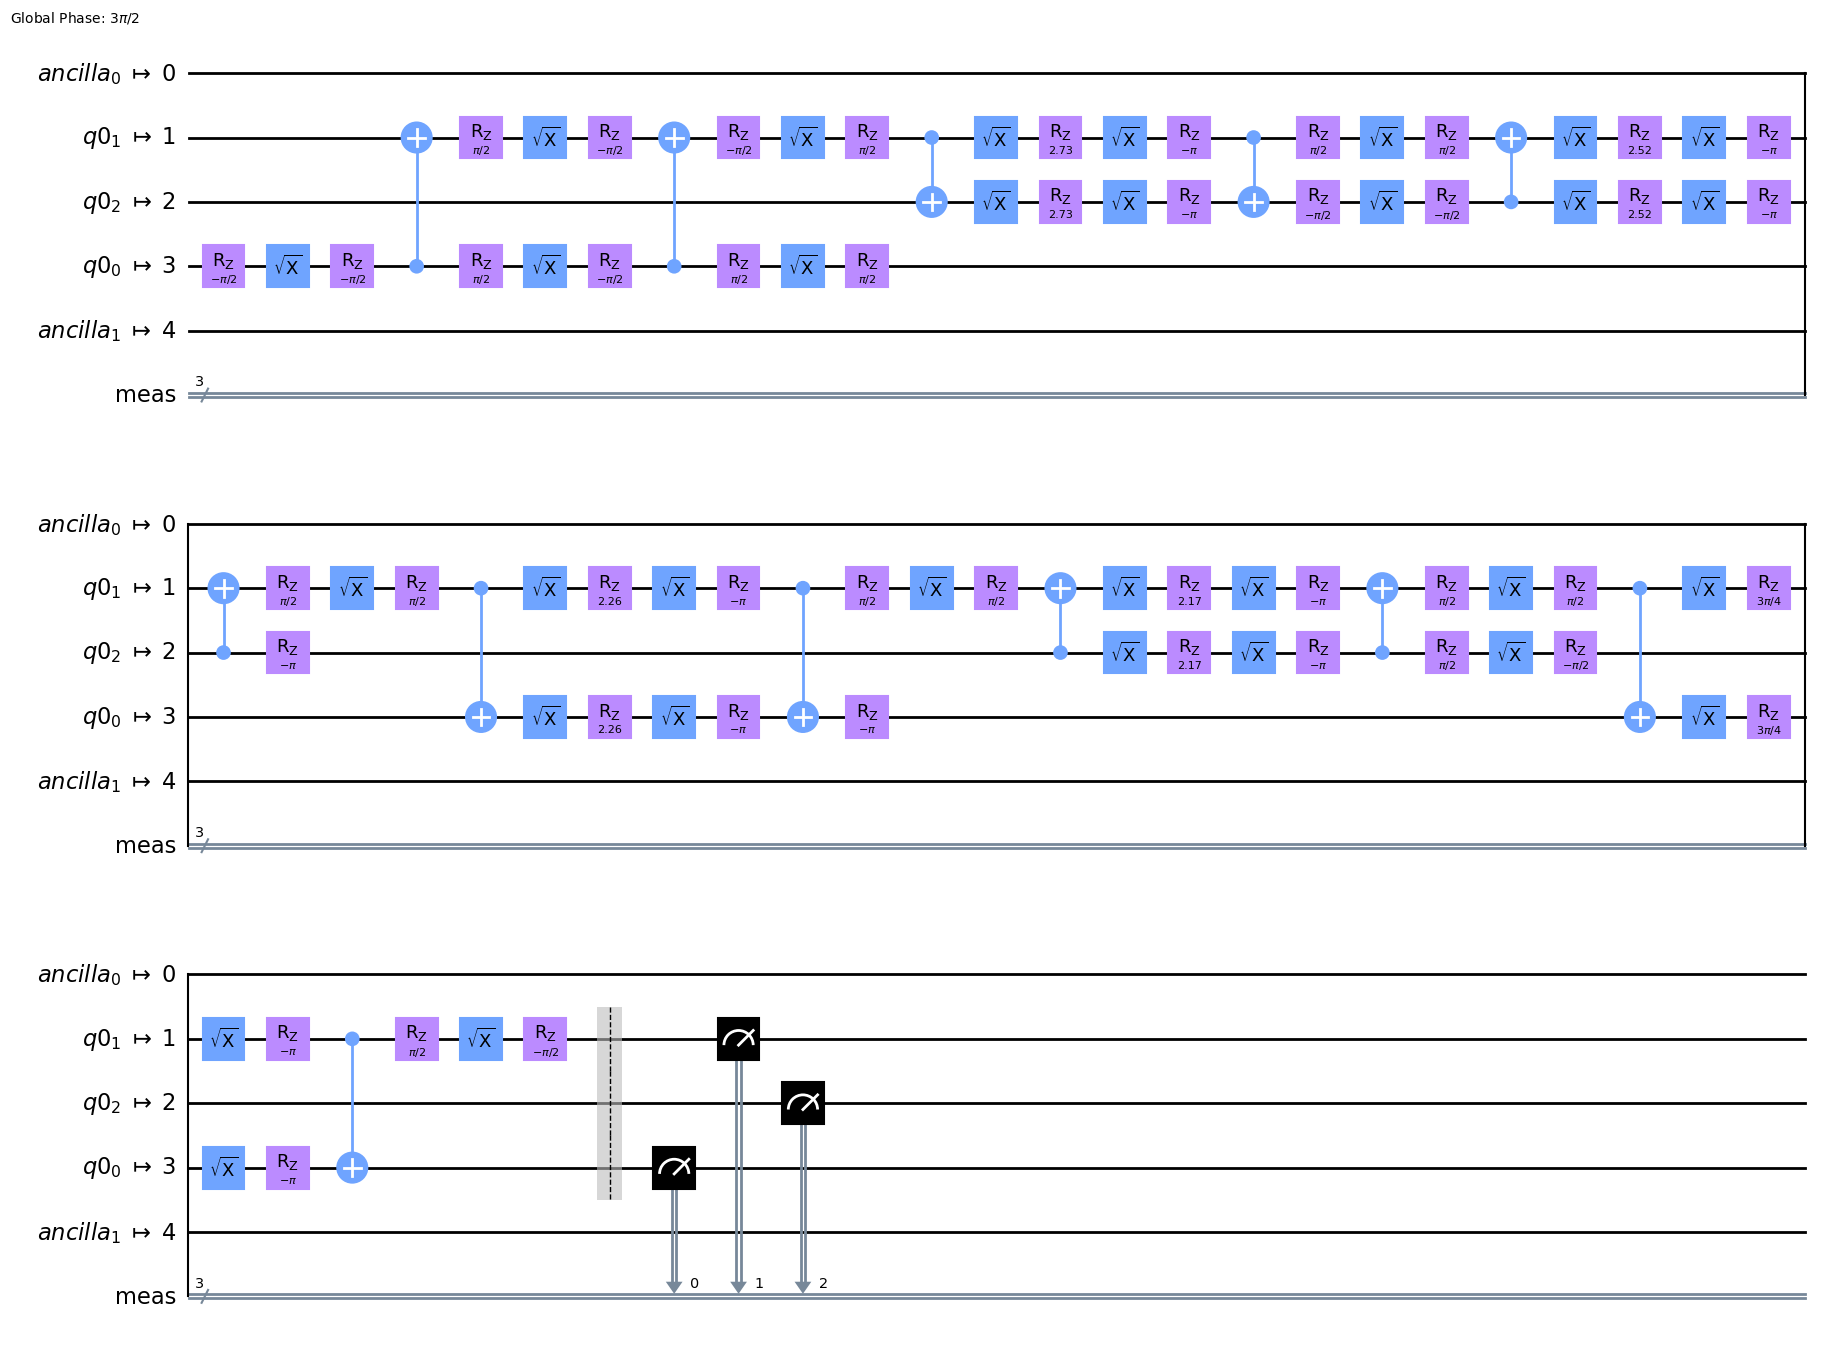

In [4]:
from qiskit_research.mzm_generation import transpile_circuit
from qiskit.test.mock import FakeLima

backend = FakeLima()
transpiled_circuit = transpile_circuit(measurement_circuit, backend)
transpiled_circuit.draw("mpl")